In [108]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List
from scipy import stats
import timeit

In [2]:
register_matplotlib_converters()
sns.set()

▶ All graphs should have a legend, a title, labeled x-axis and y-axis with units if applicable.  
▶ Don’t plot log of (physical) quantities. Please use log scales instead.  
Don’t leave plot randomly in the notebook without context. Please indicate question
numbers and comment on your results if necessary (especially if they are not what you
were expecting).  

Do not use seaborn.



TODO: adapt the legend with plt.legend, or put proper names during the computations.  
explain the graphs like in an article.

# Simulation of homogeneous Poisson Processes.

In [96]:
def poisson_process_0(lbd: float, T: float) -> List:
    t_0 = 0
    T_i = [t_0]
    s = stats.expon.rvs(scale = 1 / lbd)

    while t_0 + s <= T:
        t_0 += s
        T_i.append(t_0)
        s = stats.expon.rvs(scale = 1 / lbd)
    
    return T_i


In [97]:
def poisson_process_1(lbd: float, T: float) -> List:
    
    n = stats.poisson.rvs(lbd * T)
    u = stats.uniform.rvs(loc = 0, scale = T, size = n)
    T_i = np.sort(u)

    return T_i

In [98]:
def plot_poisson_process(T_i: List) -> None:
    eps = .1
    t = np.linspace(0, T_i[-1] + eps, num = int(T_i[-1] * 30))
    aux_fun = lambda s: np.sum([s > jump_time for jump_time in T_i])
    N_t = [aux_fun(t_k) for t_k in t]
    fig, ax = plt.subplots()
    ax.plot(t, 
             N_t)
    ax.set_title('Plot of the counting process N_t.')
    ax.set_ylabel('number of jumps')
    ax.set_xlabel('time')
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend()


Plot the poisson process for the two above functions:

In [99]:
process_realization_0 = poisson_process_0(lbd = 14., T = 25)
process_realization_1 = poisson_process_1(lbd = 2., T = 25)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


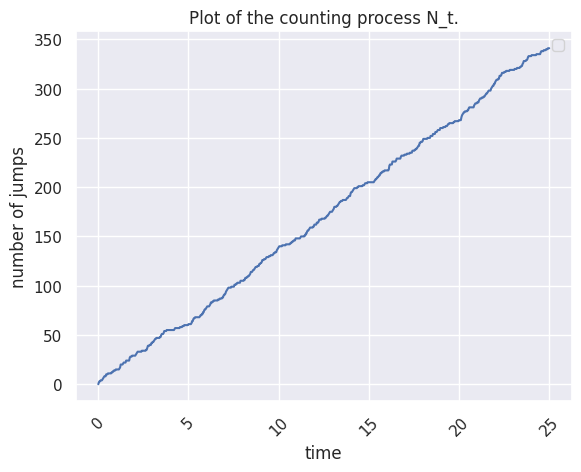

In [100]:
plot_poisson_process(process_realization_0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


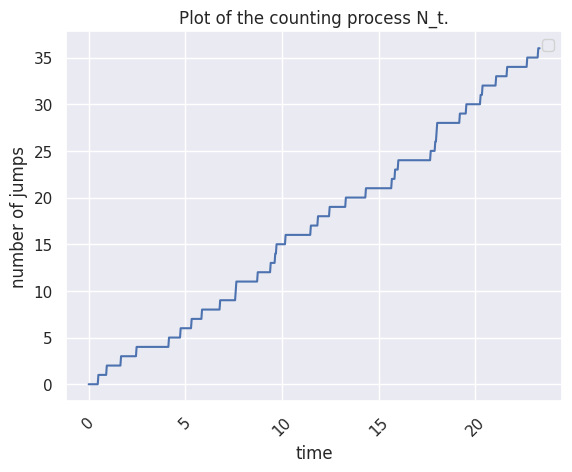

In [101]:
plot_poisson_process(process_realization_1)

## Sanity check.

It seems graphically that it is indeed a PP.

Let's see if the famous LLN for PP N_t / t --> lbd is verified for different intensities.

In [107]:
intensities = [.2, .8, 4, 28, 64]
T = 1_000

for intensity in intensities:
    N_T = len(poisson_process_1(lbd = intensity, T = T))
    print(f'real intensity is {intensity}, and obtained estimate is: {N_T / T}')

real intensity is 0.2, and obtained estimate is: 0.215
real intensity is 0.8, and obtained estimate is: 0.78
real intensity is 4, and obtained estimate is: 4.023
real intensity is 28, and obtained estimate is: 27.722
real intensity is 64, and obtained estimate is: 63.674


It seems the code is okay.

# Time comparison

At first glance, it seems the first algorithm is quicker than the second. Indeed, the former has a complexity O(N) and the latter O(N lg N) due to the sorting step. However the time execution of the former is stochastic (depends on how fast we reach T) while that of the latter is constant, given we neglect the impact of the intial sampled list on the sorting performance. Let's see what happens in practice.


In [119]:
class CodeTimer:
    def __init__(self, name=None, num_iter =None):
        self.name = " '"  + name + "'" if name else ''
        self.num_iter = num_iter

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        num_iter = float(self.num_iter) if self.num_iter is not None else 1.
        self.took = (timeit.default_timer() - self.start) * 1000.0 / num_iter
        print('Code block' + self.name + ' took: ' + str(self.took) + ' ms')

In [129]:
num_iter = 100

In [121]:
with CodeTimer('Poisson process using inter-arrival times', num_iter):
   for _ in range(num_iter):
      poisson_process_0(lbd = 1., T = 10_000)

Code block 'Poisson process using inter-arrival times' took: 1606.5356459600298 ms


In [123]:
with CodeTimer('Poisson process using order statistics', num_iter):
   for _ in range(num_iter):
      poisson_process_1(lbd = 1., T = 10_000)

Code block 'Poisson process using order statistics' took: 2.249610080034472 ms


Surprisingly, the simulation using sorting algorithms is very efficient compared to the simulation of inter-arrival times. This might be caused by the very efficient implementation of sorting algorithms in numpy.

# making it quicker.

It seems that the very efficient sorting implementations in numpy make it quicker, so let's try to see what happens with the different top sorting algorithms.

The most efficients on paper are merge-sort, heap-sort and in practice quick-sort is doing very well as well.

## Change the sorting method.

In [124]:
def poisson_process_1(lbd: float, T: float, sort: str) -> List:
    
    n = stats.poisson.rvs(lbd * T)
    u = stats.uniform.rvs(loc = 0, scale = T, size = n)
    T_i = np.sort(u, kind = sort)

    return T_i

In [130]:
sorts = ['quicksort', 'mergesort', 'heapsort', 'stable']

In [131]:
for sort in sorts:
    with CodeTimer('Poisson process using order statistics and sort ' + sort, num_iter):
        for _ in range(num_iter):
            poisson_process_1(lbd = 1., T = 10_000, sort = sort)

Code block 'Poisson process using order statistics and sort quicksort' took: 1.7065884499970707 ms
Code block 'Poisson process using order statistics and sort mergesort' took: 1.5068034599971725 ms
Code block 'Poisson process using order statistics and sort heapsort' took: 2.021536299980653 ms
Code block 'Poisson process using order statistics and sort stable' took: 1.6330214100162266 ms


In [70]:
expon = stats.expon

In [74]:
x = np.linspace(expon.ppf(0.01),

                expon.ppf(0.99), 100)

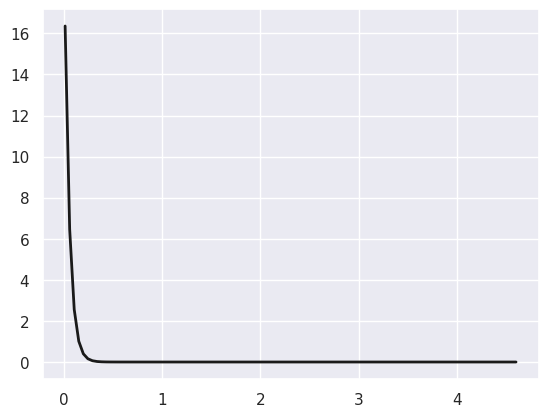

In [80]:
lam = 20
rv = expon(scale = 1/lam)
fig, ax = plt.subplots(1, 1)

ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [7]:
test = [3, 6, 8, 9]

In [8]:
np.sum([7 > e for e in test])

2

# Load data.

In [3]:
def load_data(dir: str) -> pd.DataFrame:
    

SyntaxError: unexpected EOF while parsing (2987206287.py, line 2)

## Load a sub-sample of the data.

In [4]:
df_q = pd.read_csv('./Data/RENA.PA/2017-01-02-RENA.PA-quotes.csv.gz', index_col = 0)

In [5]:
df_t = pd.read_csv('./Data/RENA.PA/2017-01-02-RENA.PA-trades.csv.gz', index_col = 0)

In [67]:
df_q.head()

,ts,bid price,bq1,ask price,aq1,bp2,bq2,ap2,aq2,bp3,...,bq10,ap10,aq10,mid price,weighted mid price,spread,duration,weighted spread,imbalance,mid price move
0,2017-01-02 09:01:18.813,84.19,35,84.31,38,84.18,35,84.34,50,84.16,...,55,84.44,55,84.25,84.247534,0.12,NaN,NaN,-0.041096,NaN
1,2017-01-02 09:01:18.813,84.19,35,84.31,128,84.18,35,84.34,50,84.16,...,55,84.44,55,84.25,84.215767,0.12,0.00,0.000,-0.570552,0.0
2,2017-01-02 09:01:19.893,84.19,35,84.31,193,84.18,35,84.34,50,84.16,...,55,84.44,55,84.25,84.208421,0.12,1.08,1.296,-0.692982,0.0
3,2017-01-02 09:01:20.553,84.19,35,84.31,193,84.18,35,84.34,50,84.16,...,55,84.44,55,84.25,84.208421,0.12,0.66,0.792,-0.692982,0.0
4,2017-01-02 09:01:20.553,84.19,35,84.31,193,84.18,35,84.33,53,84.16,...,55,84.42,75,84.25,84.208421,0.12,0.00,0.000,-0.692982,0.0


In [7]:
df_t.head()

,ts,price,volume
0,2017-01-02 09:01:15.893,84.31,90
1,2017-01-02 09:01:15.893,84.31,10
2,2017-01-02 09:01:18.813,84.31,12
3,2017-01-02 09:01:52.432,84.31,38
4,2017-01-02 09:01:52.452,84.31,62
